# Library Imports

In [1]:
import os
import cv2
import numpy as np
import tracemalloc


# Data Visualisation
import matplotlib.pyplot as plt

#Preprocessing
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils, preprocessing
from tensorflow.keras.preprocessing.image import array_to_img


#Learning rate & decay
from tensorflow.keras.optimizers.schedules import ExponentialDecay

#Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG19

objc[9091]: Class CaptureDelegate is implemented in both /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x174ffe5a0) and /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x16887c860). One of the two will be used. Which one is undefined.
objc[9091]: Class CVWindow is implemented in both /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x174ffe5f0) and /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1235e0a68). One of the two will be used. Which one is undefined.
objc[9091]: Class CVView is implemented in both /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x174ffe618) and /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewago

# Load Data

In [10]:
# import cv2
# import os


# def get_images(directory):
#     """get images local if in same directory as collab notebook"""
#     images = []
#     labels = []

#     directory_list = sorted(os.listdir(directory))
#     for i in range(len(directory_list)):
#         print(f"Getting images of {directory_list[i]}:")
#         for image in os.listdir(directory + "/" + directory_list[i]):
#             img = cv2.imread(directory + "/" + directory_list[i] + "/" + image)
#             img = crop_image(img)
#             if img.shape[0] > 1:
#                 img = cv2.resize(img, (32, 32))
#                 images.append(img)
#                 labels.append(directory_list[i])

#     return images, labels

In [4]:
def get_images(directory):
    """get images local if in same directory as collab notebook"""
    images = []
    labels = []
    directory_list = sorted(os.listdir(directory))
    for i in range(len(directory_list)):
        print(f"Getting images of {directory_list[i]}:")
        for image in os.listdir(directory + "/" + directory_list[i]):
            img = cv2.imread(directory + "/" + directory_list[i] + "/" + image)
            images.append(img)
            labels.append(directory[i])
    return images, labels

In [5]:
saving_dir = os.environ.get("SAVE_DIR") 

In [6]:
images, labels = get_images(saving_dir)

Getting images of .DS_Store:


NotADirectoryError: [Errno 20] Not a directory: '/Users/georgiantanaselea/code/stuhow/sign_language_translation/processed_image/.DS_Store'

# Preprocessing Data

In [3]:
import cv2
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

def make_image_square(x_max, x_min, y_max, y_min, h, w):
    '''used in below'''
    x_diff = x_max - x_min
    y_diff = y_max - y_min

    if y_diff > x_diff:

        length_diff =  y_diff - x_diff

        half_length_diff_max = round(length_diff/2)
        half_length_diff_min = length_diff-half_length_diff_max

        x_max = half_length_diff_max + x_max
        x_min = x_min - half_length_diff_min
        if x_min < 0:
            x_max += abs(x_min)
        if x_max > w:
            x_min -= x_max

    elif x_diff > y_diff:
        length_diff =  x_diff -  y_diff

        half_length_diff_max = round(length_diff/2)
        half_length_diff_min = length_diff-half_length_diff_max

        y_max = half_length_diff_max + y_max
        y_min = y_min - half_length_diff_min

        if y_min < 0:
            y_max += abs(y_min)
        if y_max > h:
            y_min -= y_max


    return x_max, x_min, y_max, y_min

def crop_image(image):

    mp_hands = mp.solutions.hands

    # For static images:
    mp_model = mp_hands.Hands(
        static_image_mode=True, # only static images
        max_num_hands=2, # max 2 hands detection
        min_detection_confidence=0.5) # detection confidence

    results = mp_model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    h, w, c = image.shape # get image shape

    hand_landmarks = results.multi_hand_landmarks
    crop_image = np.array([[[0]]])
    if hand_landmarks:
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h
            for lm in handLMs.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x > x_max:
                    x_max = x
                if x < x_min:
                    x_min = x
                if y > y_max:
                    y_max = y
                if y < y_min:
                    y_min = y
            y_min -= round(h/10)
            y_max += round(h/10)
            x_min -= round(h/10)
            x_max += round(h/10)

        x_max, x_min, y_max, y_min = make_image_square(x_max, x_min, y_max, y_min, h, w)

        crop_image = image[y_min:y_max, x_min:x_max]

        if x_max > w:
            crop_image = np.array([[[0]]])
        if x_min < 0:
            crop_image = np.array([[[0]]])
        if y_max > h:
            crop_image = np.array([[[0]]])
        if y_min < 0:
            crop_image = np.array([[[0]]])

    mp_model.close()
    return crop_image

def balancing(X, y):
    m = pd.Series(y).value_counts()[-1]
    unique_values = pd.Series(y).unique()
    x_sampled = []
    y_sampled = []
    for i in unique_values:
        start = y.index(i)
        end = len(y) - y[::-1].index(i)
        x1 = X[start:end]
        y1 = y[start:end]
        x_sub, y_sub = zip(*random.sample(list(zip(x1,y1)), m))
        x_sampled.extend(x_sub)
        y_sampled.extend(y_sub)

    return x_sampled, y_sampled


def preprocessing(X, y):
    """Normalise our images and categorically encode our labels"""
    LE = LabelEncoder()
    X = np.array(X)
    X = X/255
    y = LE.fit_transform(y)
    y = utils.to_categorical(y, num_classes = 29)
    return X, y

def train_val_test_split(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5)
    return X_train, X_val, X_test, y_train, y_val, y_test

def backgroud_removal(img):
    """Receives the croped image and proceeds
    to remove the background, leaving only the hand layout.
    """

    # initialize mediapipe
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    #creating white background
    imgWhite = np.ones((img.shape[0],img.shape[1],3),np.uint8)*255

    # extract segmented mask
    results = selfie_segmentation.process(img)

    #condition to apply the mask
    condition = np.stack(
      (results.segmentation_mask,) * 3, axis=-1) > 0.6

    #merging croped img with the white background
    noBackground = np.where(condition, img, imgWhite)

    return noBackground


In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(images, labels)

In [9]:
X_train, y_train = balancing(X_train, y_train)
X_train, y_train = preprocessing(X_train, y_train)
X_val, y_val = preprocessing(X_val, y_val)
X_test, y_test = preprocessing(X_test, y_test)

# Model - Transfer Learning VGG19

## Loading VGG19 Model

In [108]:
def load_transfer_model():
    model = VGG19(include_top=False,
    weights="imagenet",
    input_shape=X_train.shape[1:])
    return model

In [109]:
def set_nontrainable_layers(model):
    
    model.trainable = False
    
    return model

## Adding Predictive Layer and Building the Model

In [110]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    model = set_nontrainable_layers(model)
    flattening_layer = Flatten()
    dense_layer_1 = layers.Dense(128, activation='relu')
    dense_layer_2 = layers.Dense(64, activation='relu')
    dense_layer_3 = layers.Dense(32, activation='relu')
    prediction_layer = layers.Dense(29, activation='softmax')
    model = Sequential([
    model,
    flattening_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
    ])
    return model

In [111]:
#Setting up a learning rate exponential decay
lr_schedule = ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [112]:
def build_transfer_model():
    model = load_transfer_model()
    model = add_last_layers(model)
    opt = Adam(learning_rate = lr_schedule)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

In [113]:
model = build_transfer_model()

In [114]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 29)                957       
                                                                 
Total params: 20,101,341
Trainable params: 76,957
Non-

### Defining Early Stopping

In [115]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5, restore_best_weights = True)

## Training Model

In [116]:
history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs = 1, callbacks = [es, TqdmCallback(verbose = 0)], verbose = 0, batch_size=32)

0epoch [00:00, ?epoch/s]

2023-03-03 17:48:16.847474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-03 17:48:25.286149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [120]:
def plot_results(history):

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label = 'train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

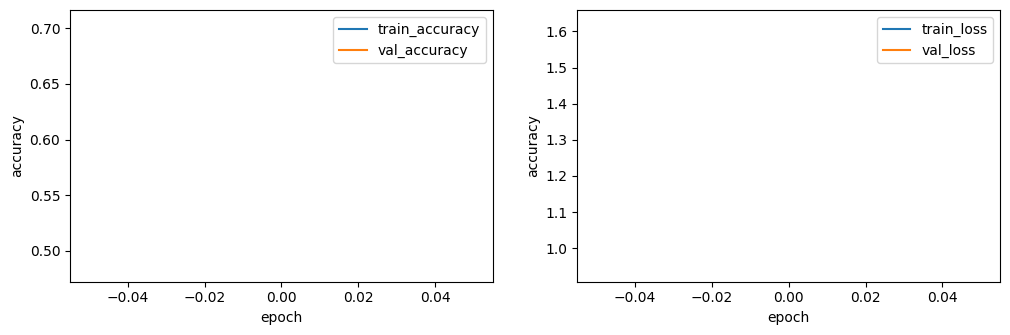

In [121]:
plot_results(history)

## Evaluating the Model

In [122]:
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

484/484 [==============================] - 9s 18ms/step - loss: 0.9338 - accuracy: 0.7078


(0.9338039755821228, 0.7077628970146179)

### Evaluating the Model using WebCam Pictures

In [123]:
webcam_test_data='/Users/georgiantanaselea/code/stuhow/raw_data/webcam-test'

In [124]:
webcam_saving_dir='/Users/georgiantanaselea/code/stuhow/sign_language_translation/processed_image_webcam'

In [125]:
def process_images(directory,saving_dir):
    """get images local if in same directory as collab notebook"""
    directory_list = sorted(os.listdir(directory))
    for i in range(len(directory_list)):
        print(f"Getting images of {directory_list[i]}:")
        for image in os.listdir(directory + "/" + directory_list[i]):
            img = cv2.imread(directory + "/" + directory_list[i] + "/" + image)
            #img = backgroud_removal(img)
            img = crop_image(img)
            if img.shape[0] > 1:
                img = cv2.resize(img, (56, 56))
                try:
                    os.mkdir(f"{saving_dir}/{directory_list[i]}")
                except:
                    pass
                cv2.imwrite(f"{saving_dir}/{directory_list[i]}/Image_{image}",img)
    print("Complete")

In [127]:
images_webcam_test, labels_webcam_test = get_images(webcam_saving_dir)

Getting images of B:
Getting images of C:
Getting images of L:
Getting images of Y:


In [128]:
X_test_webcam, y_test_webcam = preprocessing(images_webcam_test, labels_webcam_test)

In [129]:
loss_webcam, accuracy_webcam = model.evaluate(X_test_webcam, y_test_webcam)
loss_webcam, accuracy_webcam

1/1 [==============================] - 0s 84ms/step - loss: 5.9039 - accuracy: 0.0000e+00


(5.903870582580566, 0.0)